# Take a bunch of pictures from the drone on-board camera and assemble a map from them

In [46]:
FAMES_FOLDER = 'picture_parts'

In [47]:
import os


def list_directory_contents():
    items = []
    try:
        contents = os.listdir(f"{FAMES_FOLDER}/")
        for item in contents:
            items.append(f"{FAMES_FOLDER}/{item}")
        return items
    except Exception as e:
        print(f"An error occurred: {e}")


frames = list_directory_contents()

print("Contents of the FAMES folder:", frames)

Contents of the FAMES folder: ['picture_parts/f7.jpg', 'picture_parts/f6.jpg', 'picture_parts/f4.jpg', 'picture_parts/f5.jpg', 'picture_parts/f1.jpg', 'picture_parts/f2.jpg', 'picture_parts/f3.jpg', 'picture_parts/f8.jpg', 'picture_parts/f9.jpg', 'picture_parts/f10.jpg']


Loaded frames: 2
Extracted keypoints: 2
Processing sequential frame pairs...
Matching frame 0 -> 1
  Homography found with 241/249 inliers
Computed 2 transformations
Frame 0 transformation matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Frame 1 transformation matrix:
[[ 1.00517699e+00  1.85123708e-03  1.99535408e+02]
 [ 9.53871204e-04  1.00344983e+00 -1.76889046e+02]
 [ 4.56105086e-06  6.75666654e-06  9.99714538e-01]]

Creating global map...
Stitching frame 1/2
Stitching frame 2/2
Global map created!


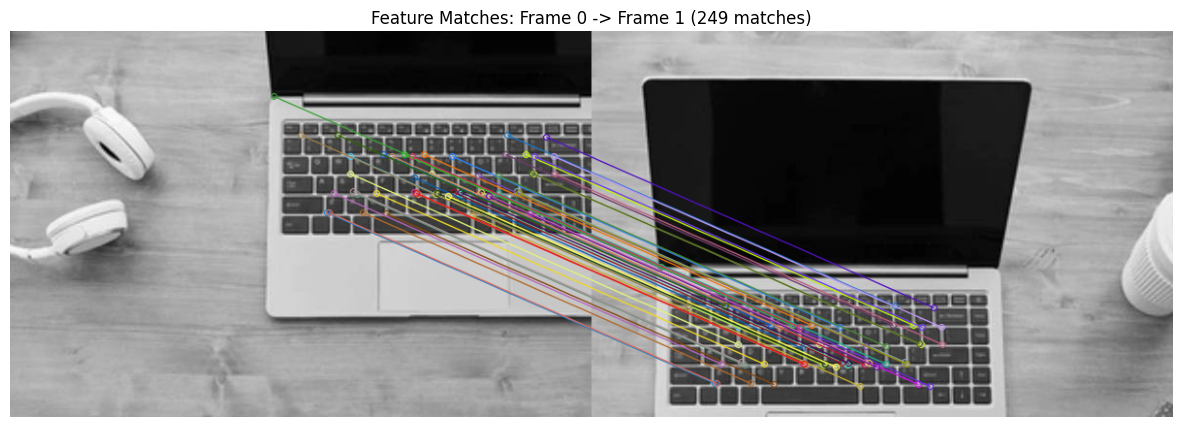

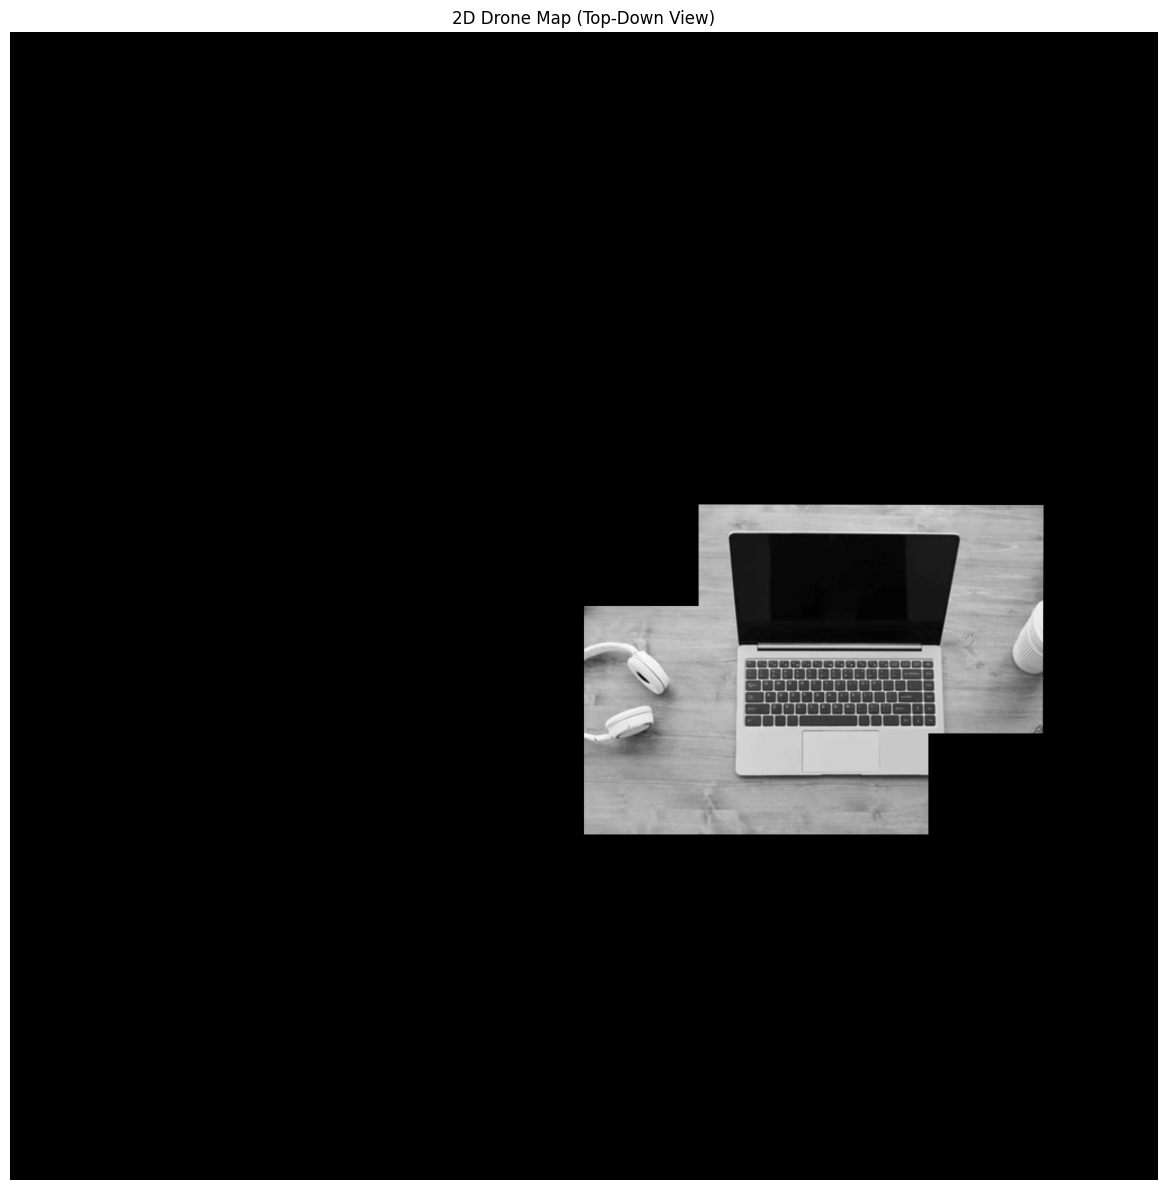

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

class FramesMapper:
    def __init__(self):
        self.frames = []
        self.keypoints = []
        self.descriptors = []
        self.images = []
        self.transformations = []
        self.global_map = None
        self.map_size = (2000, 2000)  # Default map size
        
        self.orb = cv2.ORB_create(nfeatures=1000)
        self.matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        
    def load_frames(self, frames):
        # Load frames from the provided list
        for frame in frames:
            if os.path.exists(frame):
                img = cv2.imread(frame, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    self.frames.append(frame)
                    self.images.append(img)
                    keypoints, descriptors = self.orb.detectAndCompute(img, None)
                    self.keypoints.append(keypoints)
                    self.descriptors.append(descriptors)
            else:
                print(f"Frame {frame} does not exist.")
        print(f"Loaded frames: {len(self.frames)}")
        print(f"Extracted keypoints: {len(self.keypoints)}")
    
    def match_features(self, desc1, desc2):
        """Match features between two frames."""
        if desc1 is None or desc2 is None:
            return []
            
        matches = self.matcher.match(desc1, desc2)
        matches = sorted(matches, key=lambda x: x.distance)
        
        # Keep only good matches (top 50% by distance)
        good_matches = matches[:len(matches)//2]
        return good_matches
    
    def estimate_transformation(self, kp1, kp2, matches):
        """Estimate 2D transformation (homography) between two frames"""
        if len(matches) < 4:
            return None
            
        # Extract matched keypoints - CORRECTED: frame1 points to frame2 points
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        
        # Find homography matrix using RANSAC - this maps frame1 TO frame2
        H, mask = cv2.findHomography(src_pts, dst_pts, 
                                    cv2.RANSAC, 
                                    ransacReprojThreshold=5.0)
        
        if H is None:
            return None
            
        # Count inliers
        inliers = np.sum(mask)
        print(f"  Homography found with {inliers}/{len(matches)} inliers")
        
        # We want the INVERSE - transform frame2 to frame1 coordinate system
        try:
            H_inv = np.linalg.inv(H)
            return H_inv
        except np.linalg.LinAlgError:
            print("  Homography is not invertible")
            return None
        
    def process_sequential_matching(self):
        """Process frames sequentially (frame i to frame i+1)"""
        if len(self.images) < 2:
            print("Need at least 2 frames for mapping")
            return
            
        print("Processing sequential frame pairs...")
        
        # Initialize with identity transformation for first frame
        cumulative_transform = np.eye(3, dtype=np.float32)
        self.transformations.append(cumulative_transform.copy())
        
        for i in range(len(self.images) - 1):
            print(f"Matching frame {i} -> {i+1}")
            
            # Match features
            matches = self.match_features(self.descriptors[i], self.descriptors[i+1])
            
            if len(matches) < 10:
                print(f"  Too few matches ({len(matches)}), using identity")
                self.transformations.append(cumulative_transform.copy())
                continue
            
            # Estimate transformation
            H = self.estimate_transformation(self.keypoints[i], self.keypoints[i+1], matches)
            
            if H is None:
                print("  Failed to estimate transformation, using identity")
                self.transformations.append(cumulative_transform.copy())
                continue
            
            # Accumulate transformation (chain transformations)
            cumulative_transform = cumulative_transform @ H
            self.transformations.append(cumulative_transform.copy())
            
        print(f"Computed {len(self.transformations)} transformations")
    
    def create_global_map(self):
        """Stitch all frames into a global 2D map"""
        if not self.transformations:
            print("No transformations computed")
            return
            
        print("Creating global map...")
        
        # Initialize global map
        self.global_map = np.zeros(self.map_size, dtype=np.uint8)
        
        # Calculate offset to center the map
        center_offset = np.array([[1, 0, self.map_size[1]//2],
                                 [0, 1, self.map_size[0]//2],
                                 [0, 0, 1]], dtype=np.float32)
        
        for i, (img, transform) in enumerate(zip(self.images, self.transformations)):
            print(f"Stitching frame {i+1}/{len(self.images)}")
            
            # Apply centering offset to transformation
            final_transform = center_offset @ transform
            
            # Warp image to global map coordinates
            warped = cv2.warpPerspective(img, final_transform, 
                                       (self.map_size[1], self.map_size[0]))
            
            # Blend with existing map (simple max operation)
            self.global_map = np.maximum(self.global_map, warped)
        
        print("Global map created!")
        
    def visualize_feature_matches(self, frame1_idx, frame2_idx):
        """Visualize feature matches between two frames"""
        if frame1_idx >= len(self.images) or frame2_idx >= len(self.images):
            print("Invalid frame indices")
            return
            
        matches = self.match_features(self.descriptors[frame1_idx], 
                                    self.descriptors[frame2_idx])
        
        if not matches:
            print("No matches found")
            return
            
        # Draw matches
        img_matches = cv2.drawMatches(self.images[frame1_idx], self.keypoints[frame1_idx],
                                    self.images[frame2_idx], self.keypoints[frame2_idx],
                                    matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
        plt.figure(figsize=(15, 8))
        plt.imshow(img_matches, cmap='gray')
        plt.title(f'Feature Matches: Frame {frame1_idx} -> Frame {frame2_idx} ({len(matches)} matches)')
        plt.axis('off')
        plt.show()
        
    def debug_transformations(self):
        """Debug function to print transformation matrices"""
        for i, transform in enumerate(self.transformations):
            print(f"Frame {i} transformation matrix:")
            print(transform)
            print()
        
    def visualize_map(self):
        """Display the global map"""
        if self.global_map is None:
            print("No global map to visualize")
            return
            
        plt.figure(figsize=(12, 12))
        plt.imshow(self.global_map, cmap='gray')
        plt.title('2D Drone Map (Top-Down View)')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Example usage:
mapper = FramesMapper()
mapper.load_frames(frames)
mapper.process_sequential_matching()
mapper.debug_transformations()  # Add this to see what's happening
mapper.create_global_map()
mapper.visualize_feature_matches(0, 1)
mapper.visualize_map()